## Nobel Twin Familial Cirrhosis Metabolomic Composition Analysis

**Author: Tobin Groth (tgroth@ucsd.edu)**

This is the workflow I used to analyze the composition of fecal metabolites in the NAFLD/cirrhosis patients. Based on the serum metabolite notebook `Composition_serum_analysis.ipynb` written by Stephany Flores.

In [1]:
import qiime2
import biom
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os

#for ordering
from scipy import cluster,spatial,stats 
import skbio.diversity.alpha

%matplotlib inline

os.chdir('/Users/tgroth/Google Drive/knight_twin_NAFLD/fecal_analysis')

The metadata field 'groups' is used to categorize the probands. 
- G1P is non-NAFLD controls; G1R first degree relatives
- G2P is NAFLD no advanced Fibrosis; G2R first degree relatives
- G3P is NAFLD-cirrhosis; G3R first degree relatives

### Get the number of samples and metabolites

Here the feature table feature-table-hashed.qza was generated by running qemistree.

In [2]:
#load data
table = qiime2.Artifact.load('feature_tables/fecal-ft-matched.qza')
tablepd = table.view(pd.DataFrame)
tablecount = tablepd.T
tablecount.index.names = ['id']

In [3]:
tablecount.head(5)

,TW-CO-002,TW-BT-001,TW-CA-002,TW-BD-002,TW-AV-001,TW-BS-002,TW-BJ-001,TW-CC-002,TW-BU-002,TW-BO-002,...,CIR18-002,CIR41-001,CIR63-002,CIR19-001,CIR5-001,CIR55-002,CIR26-002,CIR5-002,CIR55-001,CIR7-001
id,,,,,,,,,,,,,,,,,,,,,
00130daba4ed7c3091cebe843923b656,0.0000,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000
0035e736dc271e0ffa69ce089124dd3a,0.0000,0.0000,0.000,0.000,0.0000,0.000,0.0000,15083.7685,0.0000,0.0,...,8117.9295,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000
00b990effdb1e3547be73fc221c47da9,0.0000,0.0000,0.000,0.000,0.0000,12045.574,0.0000,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,7260.6120
00bf884546e085e1d7341e1b4d5b4c7f,0.0000,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000
00d4834e98bff02228bc6022ad218b38,6801.6965,33493.3525,6085.211,21150.335,70305.9355,6118.779,59700.9805,38590.0215,7715.6375,0.0,...,5535.7170,17005.1265,0.0,0.0,0.0,37283.7365,0.0,0.0,23233.8275,30394.2795


In [4]:
#get all metabolites
obs_arr= tablecount.index 
len(obs_arr) #number of metabolites

985

In [5]:
#get sample ids
sample_arr = tablecount.columns
len(sample_arr) #number of samples in the table

167

### Creating a dictionary with the list of samples in each disease group

In [6]:
#load the metadata
md = pd.read_table('../metadata-matched.tsv', sep='\t', index_col=0)
md.index.rename('id', inplace=True)

In [7]:
md.ATTRIBUTE_groups.value_counts()

G1P    48
G1R    37
G3R    30
G3P    22
G2P    16
G2R    14
Name: ATTRIBUTE_groups, dtype: int64

In [8]:
#make a dictionary with list of samples in each group

gp_to_samples={}
gp_list = ['G1P', 'G2P', 'G3P', 'G1R', 'G2R', 'G3R']

gp_to_samples['G1P']=[idx for idx in md[md.ATTRIBUTE_groups=='G1P'].index if idx in sample_arr]
gp_to_samples['G1R']=[idx for idx in md[md.ATTRIBUTE_groups=='G1R'].index if idx in sample_arr]
gp_to_samples['G2P']=[idx for idx in md[md.ATTRIBUTE_groups=='G2P'].index if idx in sample_arr]
gp_to_samples['G2R']=[idx for idx in md[md.ATTRIBUTE_groups=='G2R'].index if idx in sample_arr]
gp_to_samples['G3P']=[idx for idx in md[md.ATTRIBUTE_groups=='G3P'].index if idx in sample_arr]
gp_to_samples['G3R']=[idx for idx in md[md.ATTRIBUTE_groups=='G3R'].index if idx in sample_arr]

### Getting a dataframe with the classification information

In [9]:
#get the class hierarchial annotations of the metabolites
tablecpd = pd.read_csv('classified-feature-data.tsv',sep='\t',index_col=0)
tablecpd.head()

,#featureID,csi_smiles,ms2_smiles,ms2_library_match,parent_mass,retention_time,table_number,smiles,structure_source,kingdom,superclass,class,subclass,direct_parent
id,,,,,,,,,,,,,,
056d022e7adbe4ef6653efa05d5b8112,667,CCCCCCC=CCCCCCCCC(=O)OCC,missing,missing,283.2632,6.1332,1,CCCCCCC=CCCCCCCCC(=O)OCC,CSIFingerID,Organic compounds,Lipids and lipid-like molecules,Fatty Acyls,Fatty acid esters,Fatty acid esters
735cc5e83b0891f3f3f7187f8ee70423,946,CC(C)CC(=NCCCCCN)O,missing,missing,187.1805,0.9041,1,CC(C)CC(=NCCCCCN)O,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
3602250da02502454e038abb20d0bb7e,1179,missing,missing,missing,284.2949,4.5907,1,missing,missing,unclassified,unclassified,unclassified,unclassified,unclassified
d66ab13eb87fd0f6688ef1f5332cf25f,330,C1=CC=C(C=C1)C=CO,missing,missing,121.0640,1.6710,1,C1=CC=C(C=C1)C=CO,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
3a2a812b26a0df79b008f0ca30844218,122,C1=CC=C(C=C1)CC(C(=O)O)N,missing,Phenylalanine,166.0873,9.8312,1,C1=CC=C(C=C1)CC(C(=O)O)N,CSIFingerID,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",Phenylalanine and derivatives


In [10]:
tablecpd["hierarchy"] = tablecpd["kingdom"] +"; "+ tablecpd["superclass"] +"; "+ tablecpd["class"] +"; "+ tablecpd["subclass"] +"; "+ tablecpd["direct_parent"]

In [11]:
tableclpd = tablecpd[['hierarchy']]

In [12]:
#add the hierarchial information to the count feature table
tableclassified = pd.merge(tablecount,
                 tableclpd,
                 on='id', 
                 how='left')

In [13]:
tableclassified.head(3)

,TW-CO-002,TW-BT-001,TW-CA-002,TW-BD-002,TW-AV-001,TW-BS-002,TW-BJ-001,TW-CC-002,TW-BU-002,TW-BO-002,...,CIR41-001,CIR63-002,CIR19-001,CIR5-001,CIR55-002,CIR26-002,CIR5-002,CIR55-001,CIR7-001,hierarchy
id,,,,,,,,,,,,,,,,,,,,,
00130daba4ed7c3091cebe843923b656,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,Organic compounds; Benzenoids; Benzene and sub...
0035e736dc271e0ffa69ce089124dd3a,0.0,0.0,0.0,0.0,0.0,0.000,0.0,15083.7685,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,unclassified; unclassified; unclassified; uncl...
00b990effdb1e3547be73fc221c47da9,0.0,0.0,0.0,0.0,0.0,12045.574,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7260.612,unclassified; unclassified; unclassified; uncl...


In [14]:
tableclassified.reset_index().to_csv('composition_analysis/fecal-ft-wclassification.csv', index= False)

### Get the frequency at the direct parent level

In [15]:
tablepd = pd.read_csv('composition_analysis/fecal-ft-wclassification.csv', index_col= 0)

In [16]:
#checking for missing taxonomic information
len(tablepd[tablepd['hierarchy']=="unclassified; unclassified; unclassified; unclassified; unclassified"])

530

In [17]:
#removing the unclassified features
indexNames = tablepd[tablepd['hierarchy']=="unclassified; unclassified; unclassified; unclassified; unclassified"].index
tablepd.drop(indexNames , inplace=True)
tablepd.shape

(455, 168)

In [18]:
#get all metabolites 
obs_arr= tablepd.index 
len(obs_arr) #number of metabolites

455

In [19]:
#get sample ids
sample_arr = tablepd.columns
len(sample_arr)-1 #number of samples in the table, not counting the hierarchy

167

In [20]:
# to store average frequencies of metabolite groups across samples in a group at the direct parent level
t1=time.time()
gp_to_taxa={} 
for gp in gp_list: #for each group
    gp_to_taxa[gp]={}

for gp in gp_list:
    for sample in gp_to_samples[gp]: #for sample i in the whole sample list (e.g. cirrhosis,TW)
        weighted_sampotus=np.zeros(len(obs_arr)) #creates a list with zeros that's as long as the num of metabolites 
        sample_otu=np.array(tablepd[sample]) #getting an array of all the feature counts per sample
        otu_freqsum=np.sum(sample_otu) #sum of all the feature counts for one sample
        if otu_freqsum == 0:
            continue
        else:
            nz_ind=sample_otu!=0
            for i in range(len(nz_ind)):
                if nz_ind[i]:
                    weighted_sampotus[i]=sample_otu[i]/float(otu_freqsum) #normalizing freq. of an otu in sample with the sum of frequencies of all otus in the sample
                    taxa = tablepd['hierarchy'][i]
                    taxa_bins=[]
                    for q in range(len(taxa)): #loop to get all the taxonomic bins that an otu falls into
                        taxa_bins.append(taxa)
                        #taxa.pop()
                    for taxa_bin in taxa_bins: #creating a dict of dict to store weights for each otu's taxa bin within each group
                        if taxa_bin not in gp_to_taxa[gp].keys():
                            gp_to_taxa[gp][taxa_bin]=weighted_sampotus[i]
                        else:
                            gp_to_taxa[gp][taxa_bin]+=weighted_sampotus[i] 
    for taxa_bin in gp_to_taxa[gp].keys():
        gp_to_taxa[gp][taxa_bin]=gp_to_taxa[gp][taxa_bin]/len(gp_to_samples[gp]) #averaging for all samples within an group
t2=time.time()
print(t2-t1)  

1.0338408946990967


In [21]:
#filter taxlevel: kingdom level=0; phylum level=1 
#these are functions
def filter_tax(gp_to_taxa, taxlevel):
    f_gp_to_taxa={}
    for gp in gp_list:
        f_gp_to_taxa[gp]={}
        for taxa in gp_to_taxa[gp].keys():
            if len(taxa.split(';'))==taxlevel+1: #this will only work for the direct direct parent level
                f_gp_to_taxa[gp][taxa]=gp_to_taxa[gp][taxa]
    return f_gp_to_taxa

#normalize empo levels to sum to 1
def norm(f_gp_to_taxa):
    nf_gp_to_taxa={}
    for gp in gp_list:
        nf_gp_to_taxa[gp]={}
        tot=sum(f_gp_to_taxa[gp].values())
        for taxa in f_gp_to_taxa[gp].keys():
            nf_gp_to_taxa[gp][taxa]=f_gp_to_taxa[gp][taxa]/tot
    return nf_gp_to_taxa

In [22]:
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa, 4))).fillna(0).to_csv('composition_analysis/directparent_groupwise.csv', sep=',')

### Frequency at kingdom, superclass, class, and subclass level

In [23]:
tablepd = pd.read_csv('composition_analysis/fecal-ft-wclassification.csv', index_col= 0)

#get classification information for the other taxonomic levels
tablepd[['kingdom','superclass','class','subclass','directparent']] = tablepd.hierarchy.str.split(';', expand=True)

In [24]:
# to store average frequencies of bacterial groups across samples in a group at different hierarchial levels
def get_group_freqn(tablepd,tax_level):
    
    indexNames = tablepd[tablepd[tax_level]==" unclassified"].index
    tablepd.drop(indexNames , inplace=True)
    
    #subclass
    tablepd['subclass']=tablepd['kingdom']+"; "+ tablepd['superclass']+"; "+ tablepd['class']+"; "+ tablepd['subclass']
    #class
    tablepd['class']=tablepd['kingdom']+"; "+ tablepd['superclass']+"; "+ tablepd['class']
    #superclass
    tablepd['superclass']=tablepd['kingdom']+"; "+ tablepd['superclass']
    #kingdom
    tablepd['kingdom']=tablepd['kingdom']
    
    gp_to_taxa={} 
    for gp in gp_list: #for each group
        gp_to_taxa[gp]={}

    for gp in gp_list:
        for sample in gp_to_samples[gp]: #for sample i in the whole sample list (e.g. cirrhosis,TW)
            weighted_sampotus=np.zeros(len(obs_arr)) #creates a lost with zeros that's as long as the num of metabolites 
            sample_otu=np.array(tablepd[sample]) #getting an array of all the feature counts per sample
            otu_freqsum=np.sum(sample_otu) #sum of all the feature counts for one sample
            if otu_freqsum == 0:
                continue
            else:
                nz_ind=sample_otu!=0
                for i in range(len(nz_ind)):
                    if nz_ind[i]:
                        weighted_sampotus[i]=sample_otu[i]/float(otu_freqsum) #normalizing freq. of an otu in sample with the sum of frequencies of all otus in the sample
                        taxa = tablepd[tax_level][i] #change this to hierarchial level
                        taxa_bins=[]
                        for q in range(len(taxa)): #loop to get all the taxonomic bins that an otu falls into
                            taxa_bins.append(taxa)
                            #taxa.pop()
                        for taxa_bin in taxa_bins: #creating a dict to store weights for each otu's taxa bin within each group
                            if taxa_bin not in gp_to_taxa[gp].keys():
                                gp_to_taxa[gp][taxa_bin]=weighted_sampotus[i]
                            else:
                                gp_to_taxa[gp][taxa_bin]+=weighted_sampotus[i] 
        for taxa_bin in gp_to_taxa[gp].keys():
            gp_to_taxa[gp][taxa_bin]=gp_to_taxa[gp][taxa_bin]/len(gp_to_samples[gp]) #averaging for all samples within an group
    


    return gp_to_taxa 

In [25]:
gp_to_taxa_sbc=get_group_freqn(tablepd,"subclass")

In [26]:
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa_sbc, 3))).fillna(0).to_csv('composition_analysis/subclass_groupwise.csv', sep=',')

## 1. comparing the gut microbial composition of non-NAFLD controls (G1P) vs. NAFLD without advanced fibrosis (G2P) vs. NAFLD-cirrhosis (G3P)

Only plotting top n taxa, rest in 'others'. The rationale is to represent top taxonomic/hierarchial groups and keep the composition of 'others' category consistent.

In [27]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
plt.rcParams['figure.figsize'] = (5.0, 10.0)

In [28]:
#calculate top n taxa for a particular level
def toptaxa(nfgptaxa,numbertaxa):
    wt_tup=[]
    top_taxa=[]
    for gp in nfgptaxa: #lop to make a tupule of (wt, taxa)
        for taxa in nfgptaxa[gp].keys():
            wt_tup.append((nfgptaxa[gp][taxa],taxa))
    wt_tup=sorted(wt_tup, reverse=True)
    
    for tup in wt_tup: #getting top taxa
        if len(top_taxa)<numbertaxa and tup[1] not in top_taxa:
            top_taxa.append(tup[1])
    return top_taxa

In [29]:
#group the taxa which are not in top n taxa u 'others'
def add_others2(nfgptaxa, top_taxa):
    gp_to_taxa_rev={}
    for gp in nfgptaxa:
        gp_to_taxa_rev[gp]={}
        others=0
        for taxa in nfgptaxa[gp].keys():
            if taxa not in top_taxa:
                others+=nfgptaxa[gp][taxa]
            else:
                gp_to_taxa_rev[gp][taxa]=nfgptaxa[gp][taxa]
            gp_to_taxa_rev[gp]['others']=others
    return gp_to_taxa_rev

In [30]:
#make a dictionary for the colors to use on the plot
def top_color(color_list, top_taxa):
    top_color = {top_taxa[i]: color_list[i] for i in range(len(top_taxa))}
    top_color.update( {'others' : '#bab0ac'} )
    return top_color

In [31]:
#this is to assign more colors to the plot
seed = ['#910074','#e8e700','#0023bf','#5eff9f','#ff2563','#356f00','#bc92ff',
        '#ff7539','#0099b6','#ff768f','#002110','#daffde','#001338','#ffb0c2',
        '#370600']

In [34]:
#new plotting function that takes numbertaxa (number of taxa to be plotted i.e. top n) intead of cutoff (bottom 2% etc.) like in previous figures
def plot_gp2(gp_to_taxa, taxlevel, cnames, numbertaxa, gplist=['G1P', 'G1R', 'G2P', 'G2R', 'G3P', 'G3R'], 
             lablist = None, color='random', wide = False):
    
    fgptaxa=filter_tax(gp_to_taxa, taxlevel) #get the taxa info
    nfgptaxa=norm(fgptaxa) #normalize the counts
    top_taxa=toptaxa(nfgptaxa,numbertaxa) #get the taxa that are most represented
    onfgptaxa=add_others2(nfgptaxa, top_taxa) #collapse all other taxa to others
    onfgptaxa_df = pd.DataFrame(onfgptaxa).fillna(0) #make a df
    topc = top_color(cnames,top_taxa) #get distinct colors for each element
    
    #save source
    #onfgptaxa_df.to_csv('tables/composition_analysis_tables/source_data_top10composition_groups_wrels.csv', sep=',')
    #onfgptaxa_df.to_csv('tables/composition_analysis_tables/source_data_top10composition_groups.csv', sep=',')
    #onfgptaxa_df.to_csv('tables/composition_analysis_tables/source_data_top12composition_groups.csv', sep=',')
    onfgptaxa_df.to_csv('composition_analysis/source_data_top12composition_groups_wrels.csv', sep=',')

    from scipy.cluster import hierarchy
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import pdist, squareform

    gp_list2 = gplist
    fig = plt.figure()
    
    if lablist == None:
        lablist = gp_list2
    ind=np.arange(0, len(gp_list2)/2, step=0.5)
    count_ind=0
    taxa_list=[]

    #plotting barplot & legend
    ax = fig.add_subplot(1, 1, 1)
    
    
    for gp in gp_list2: #for each group
        taxa_sorted=sorted(onfgptaxa[gp].keys())
        tmp=[]
        count_tmp=0
        for taxa in taxa_sorted:
            tmp.append(onfgptaxa[gp][taxa])
            if count_tmp==0:
                bottom=0
            else:
                bottom+=tmp[count_tmp-1] #i think this stacks it 
            if taxa not in taxa_list:
                taxa_list.append(taxa)
                lab=taxa
            else:
                lab=''
            if color=='random':
                p1=plt.bar(ind[count_ind],tmp[count_tmp],width=0.4,
                           bottom=bottom, label=lab) #, color=colors_taxa[taxa])
                count_tmp+=1 
            elif color=='assigned':
                p1=plt.bar(ind[count_ind],tmp[count_tmp],width=0.4, color=topc[taxa], 
                           bottom=bottom, label=lab) #, color=colors_taxa[taxa])color=cnames[taxa], 
                count_tmp+=1 
        count_ind+=1 

    handles, labels = ax.get_legend_handles_labels()
    plt.ylabel('relative abundance of hierarchial group',fontsize=20)
    plt.xticks(ind, lablist, rotation=0, fontsize=25)
    plt.xticks(fontsize=18)
    plt.ylim([0,1])
    ax.set
    
    try:
        import operator
        hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
        handles2, labels2 = zip(*hl)
        ax.legend(handles2, labels2, loc='best', bbox_to_anchor=(-1, 1),fontsize=20)
    except:
        print('legend problem')
        
    return plt

### composition plot @ direct parent level

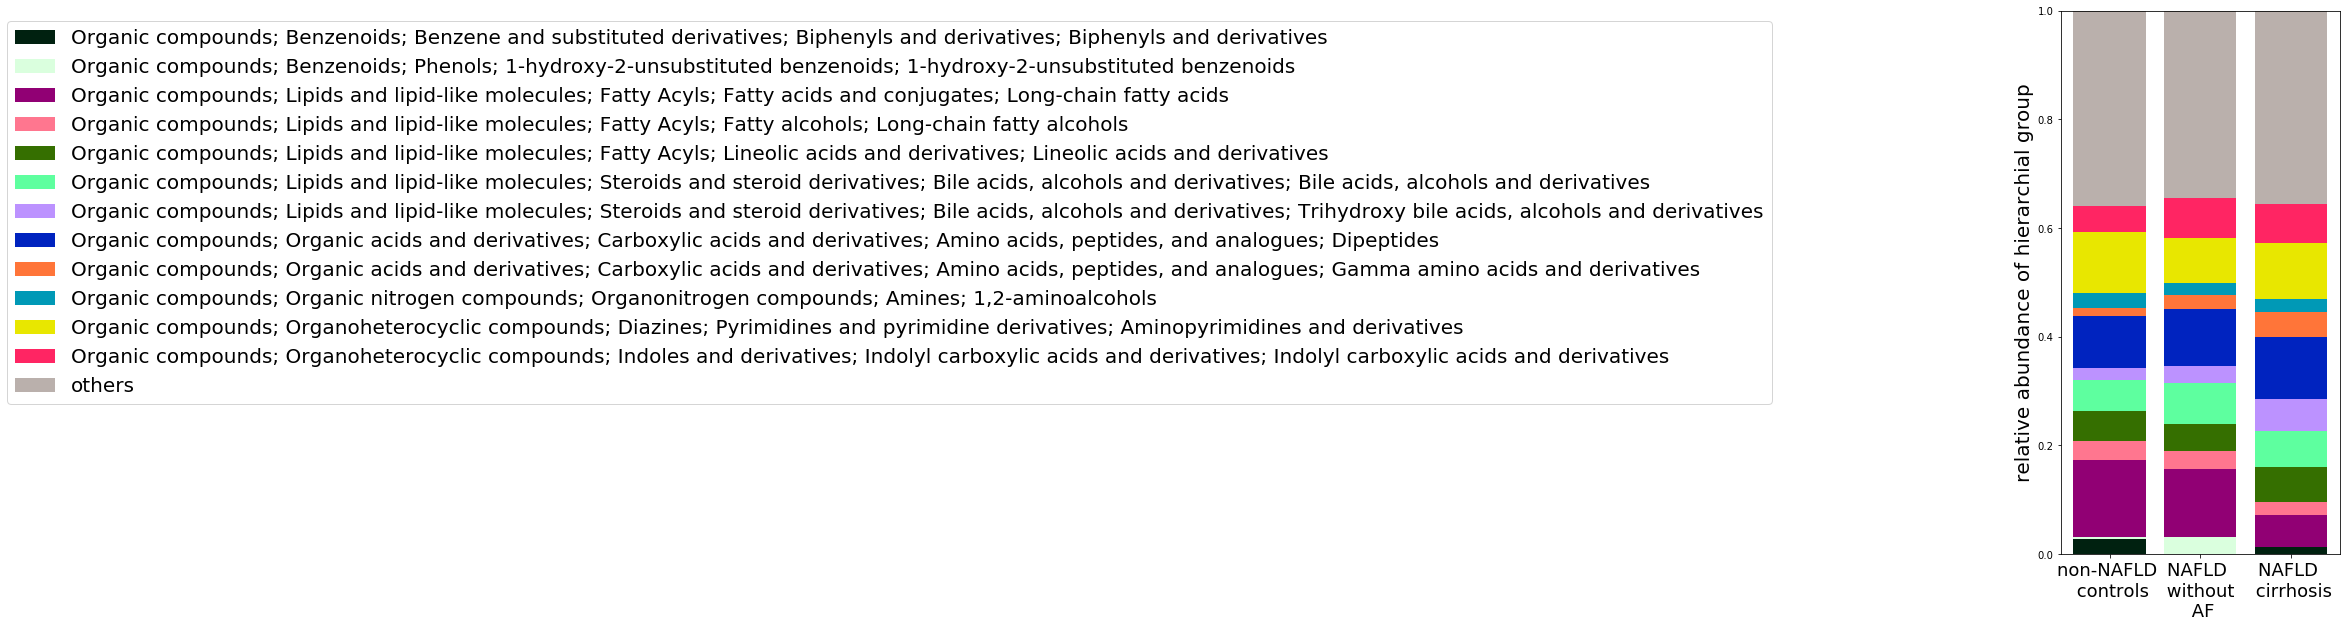

In [35]:
bar = plot_gp2(gp_to_taxa, 4,cnames=seed, numbertaxa=12, gplist=['G1P', 'G2P', 'G3P'], 
              color='assigned', lablist=['non-NAFLD \n controls', 'NAFLD \n without \n AF','NAFLD \n cirrhosis'], wide = False)
bar.savefig('composition_analysis/figures/direct_parent_top12_G1PG2PG3P_leg.pdf', bbox_to_inches='tight')

**observations from G1P vs. G3P**
- See an increase in bile acids, specifically trihydoxy bile acids
- Decrease in fatty acyls, both fatty acids and fatty alchohols
- Increase in amino acids and peptides

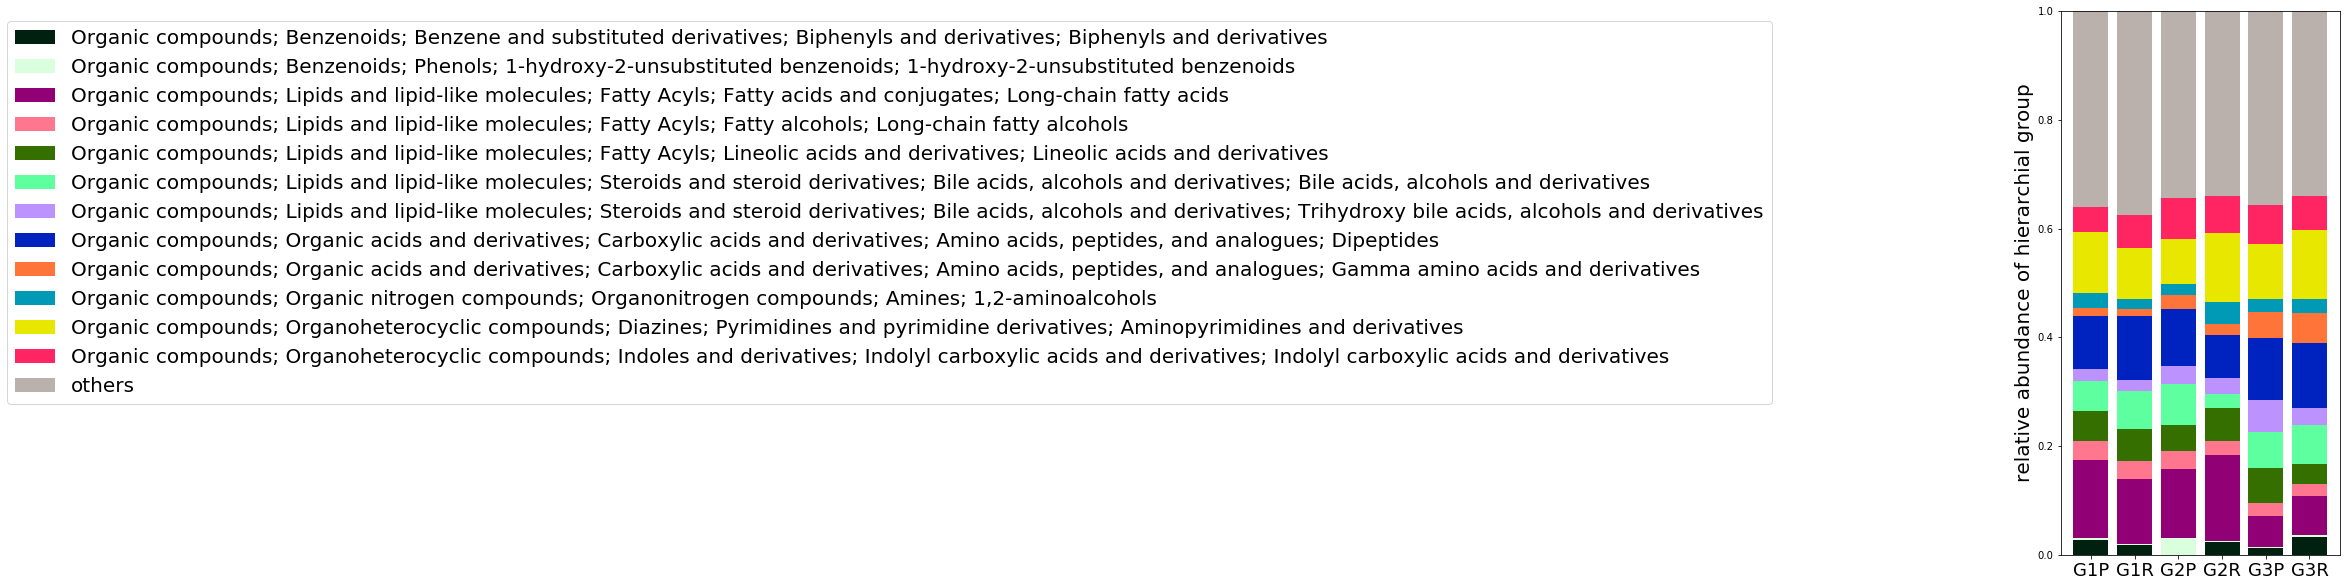

In [37]:
bar = plot_gp2(gp_to_taxa, 4,cnames=seed, numbertaxa=12, gplist=['G1P', 'G1R', 'G2P', 'G2R', 'G3P', 'G3R'], 
              color='assigned', wide = True)
bar.savefig('composition_analysis/figures/direct_parent_top12_all_group.pdf', bbox_to_inches='tight')

**This analyses can be repeated for other taxonomic levels by simply changing the value of the argument 'taxlevel' in the function plot_gp2(). Kingdom=1, phylum=2, class=3 and so on**

### Future Directions

See some similarities between the serum results that Steph performed previouslt but also some new biomarkers. We don't see any change in bilirubens but we do see a change in bile acids as well as amino acids and fatty acids. 

## Composition of Songbird Top25/Bot25
After performing ML analysis on the songbird feature sets, I want to look into the composition of the best performing feature set.

In [8]:
#load in the songbird top+bot 25 features
sb_topbot = pd.read_csv('./fecal_ml_analysis/sonbird_topbot.txt',sep='\t',header=None,names=['feature_id'])
sb_topbot.head(3)

,feature_id
0,fb758530086adf438d5ebe8f83847f2d
1,0ba75f593218ef056eefaeab285ae839
2,cdf8d23687cfc324485e2bd3e0094ff2


In [11]:
sb_tablecount = tablecount.loc[sb_topbot.feature_id]
sb_tablecount.shape

(50, 206)

In [12]:
#get all metabolites
sb_obs_arr= sb_tablecount.index 
len(sb_obs_arr) #number of metabolites

50

In [13]:
#get sample ids
sb_sample_arr = sb_tablecount.columns
len(sb_sample_arr) #number of samples in the table

206

### Creating a dictionary with the list of samples in each disease group

In [14]:
#load the metadata
md = pd.read_table('fecal_metadata.tsv', sep='\t', index_col=0)
md.index.rename('id', inplace=True)

In [15]:
md.ATTRIBUTE_groups.value_counts()

G1P    56
G1R    42
G3R    34
G3P    24
G2P    18
G2R    17
Name: ATTRIBUTE_groups, dtype: int64

In [17]:
#make a dictionary with list of samples in each group

gp_to_samples={}
gp_list = ['G1P', 'G2P', 'G3P', 'G1R', 'G2R', 'G3R']

gp_to_samples['G1P']=[idx for idx in md[md.ATTRIBUTE_groups=='G1P'].index if idx in sb_sample_arr]
gp_to_samples['G1R']=[idx for idx in md[md.ATTRIBUTE_groups=='G1R'].index if idx in sb_sample_arr]
gp_to_samples['G2P']=[idx for idx in md[md.ATTRIBUTE_groups=='G2P'].index if idx in sb_sample_arr]
gp_to_samples['G2R']=[idx for idx in md[md.ATTRIBUTE_groups=='G2R'].index if idx in sb_sample_arr]
gp_to_samples['G3P']=[idx for idx in md[md.ATTRIBUTE_groups=='G3P'].index if idx in sb_sample_arr]
gp_to_samples['G3R']=[idx for idx in md[md.ATTRIBUTE_groups=='G3R'].index if idx in sb_sample_arr]

### Getting a dataframe with the classification information

In [18]:
#get the class hierarchial annotations of the metabolites
tablet = qiime2.Artifact.load('fecal_qemistree_analysis/classified-feature-table-data.qza')
tablecpd = tablet.view(pd.DataFrame)

In [19]:
tablecpd.head(5)
tablecpd["hierarchy"] = tablecpd["kingdom"] +"; "+ tablecpd["superclass"] +"; "+ tablecpd["class"] +"; "+ tablecpd["subclass"] +"; "+ tablecpd["direct_parent"]

In [20]:
tableclpd = tablecpd[['hierarchy']]

In [21]:
#add the hierarchial information to the count feature table
sb_tableclassified = pd.merge(sb_tablecount, tableclpd, on='id', how='left')

In [22]:
sb_tableclassified.head(3)

,TW-CO-002_BG5_01_29911.mzXML,TW-BT-001_BC11_01_29853.mzXML,TW-CA-002_RC6_01_29817.mzXML,TW-BD-002_BC4_01_29860.mzXML,TW-AQ-002_RNA_BF4_01_29899.mzXML,TW-AV-001_RG2_01_29762.mzXML,TW-BS-002_BH9_01_29920.mzXML,TW-BJ-001_RNA_BH8_01_29921.mzXML,TW-BI-001_RNA_BG7_01_29909.mzXML,TW-CH-001_RE1_01_29735.mzXML,...,CIR19-001_RB12_01_29707.mzXML,CIR5-001_RF10_01_29757.mzXML,FS-CIR2-002_RF11_01_29758.mzXML,CIR55-002_BD8_01_29869.mzXML,CIR26-002_BE8_01_29882.mzXML,CIR5-002_RD5_01_29726.mzXML,CIR55-001_BD7_01_29870.mzXML,CIR7-001_BB6_01_29845.mzXML,CIR5-003_RF6_01_29753.mzXML,hierarchy
id,,,,,,,,,,,,,,,,,,,,,
fb758530086adf438d5ebe8f83847f2d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,59620.4735,0.0,0.0,0.0000,0.0,unclassified; unclassified; unclassified; uncl...
0ba75f593218ef056eefaeab285ae839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,55327.5430,0.0,0.0,5322.5995,0.0,Organic compounds; Organic oxygen compounds; O...
cdf8d23687cfc324485e2bd3e0094ff2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,42007.7560,0.0,0.0,5421.9445,0.0,Organic compounds; Organic acids and derivativ...


In [23]:
sb_tableclassified.reset_index().to_csv('fecal_composition_analysis/sb_feature-table-hashed-wclassification.csv', index= False)

### Get the frequency at the direct parent level

In [24]:
sb_tablepd = pd.read_csv('fecal_composition_analysis/sb_feature-table-hashed-wclassification.csv', index_col= 0)

In [25]:
#checking for missing taxonomic information
len(sb_tablepd[sb_tablepd['hierarchy']=="unclassified; unclassified; unclassified; unclassified; unclassified"])

23

In [26]:
#removing the unclassified features
indexNames = sb_tablepd[sb_tablepd['hierarchy']=="unclassified; unclassified; unclassified; unclassified; unclassified"].index
sb_tablepd.drop(indexNames , inplace=True)
sb_tablepd.shape

(27, 207)

In [28]:
#get all metabolites 
sb_obs_arr= sb_tablepd.index 
len(sb_obs_arr) #number of metabolites

27

In [29]:
#get sample ids
sb_sample_arr = sb_tablepd.columns
len(sb_sample_arr)-1 #number of samples in the table, not counting the hierarchy

206

In [31]:
# to store average frequencies of metabolite groups across samples in a group at the direct parent level
t1=time.time()
gp_to_taxa={} 
for gp in gp_list: #for each group
    gp_to_taxa[gp]={}

for gp in gp_list:
    for sample in gp_to_samples[gp]: #for sample i in the whole sample list (e.g. cirrhosis,TW)
        weighted_sampotus=np.zeros(len(sb_obs_arr)) #creates a list with zeros that's as long as the num of metabolites 
        sample_otu=np.array(sb_tablepd[sample]) #getting an array of all the feature counts per sample
        otu_freqsum=np.sum(sample_otu) #sum of all the feature counts for one sample
        if otu_freqsum == 0:
            continue
        else:
            nz_ind=sample_otu!=0
            for i in range(len(nz_ind)):
                if nz_ind[i]:
                    weighted_sampotus[i]=sample_otu[i]/float(otu_freqsum) #normalizing freq. of an otu in sample with the sum of frequencies of all otus in the sample
                    taxa = sb_tablepd['hierarchy'][i]
                    taxa_bins=[]
                    for q in range(len(taxa)): #loop to get all the taxonomic bins that an otu falls into
                        taxa_bins.append(taxa)
                        #taxa.pop()
                    for taxa_bin in taxa_bins: #creating a dict of dict to store weights for each otu's taxa bin within each group
                        if taxa_bin not in gp_to_taxa[gp].keys():
                            gp_to_taxa[gp][taxa_bin]=weighted_sampotus[i]
                        else:
                            gp_to_taxa[gp][taxa_bin]+=weighted_sampotus[i] 
    for taxa_bin in gp_to_taxa[gp].keys():
        gp_to_taxa[gp][taxa_bin]=gp_to_taxa[gp][taxa_bin]/len(gp_to_samples[gp]) #averaging for all samples within an group
t2=time.time()
print(t2-t1)  

0.08037686347961426


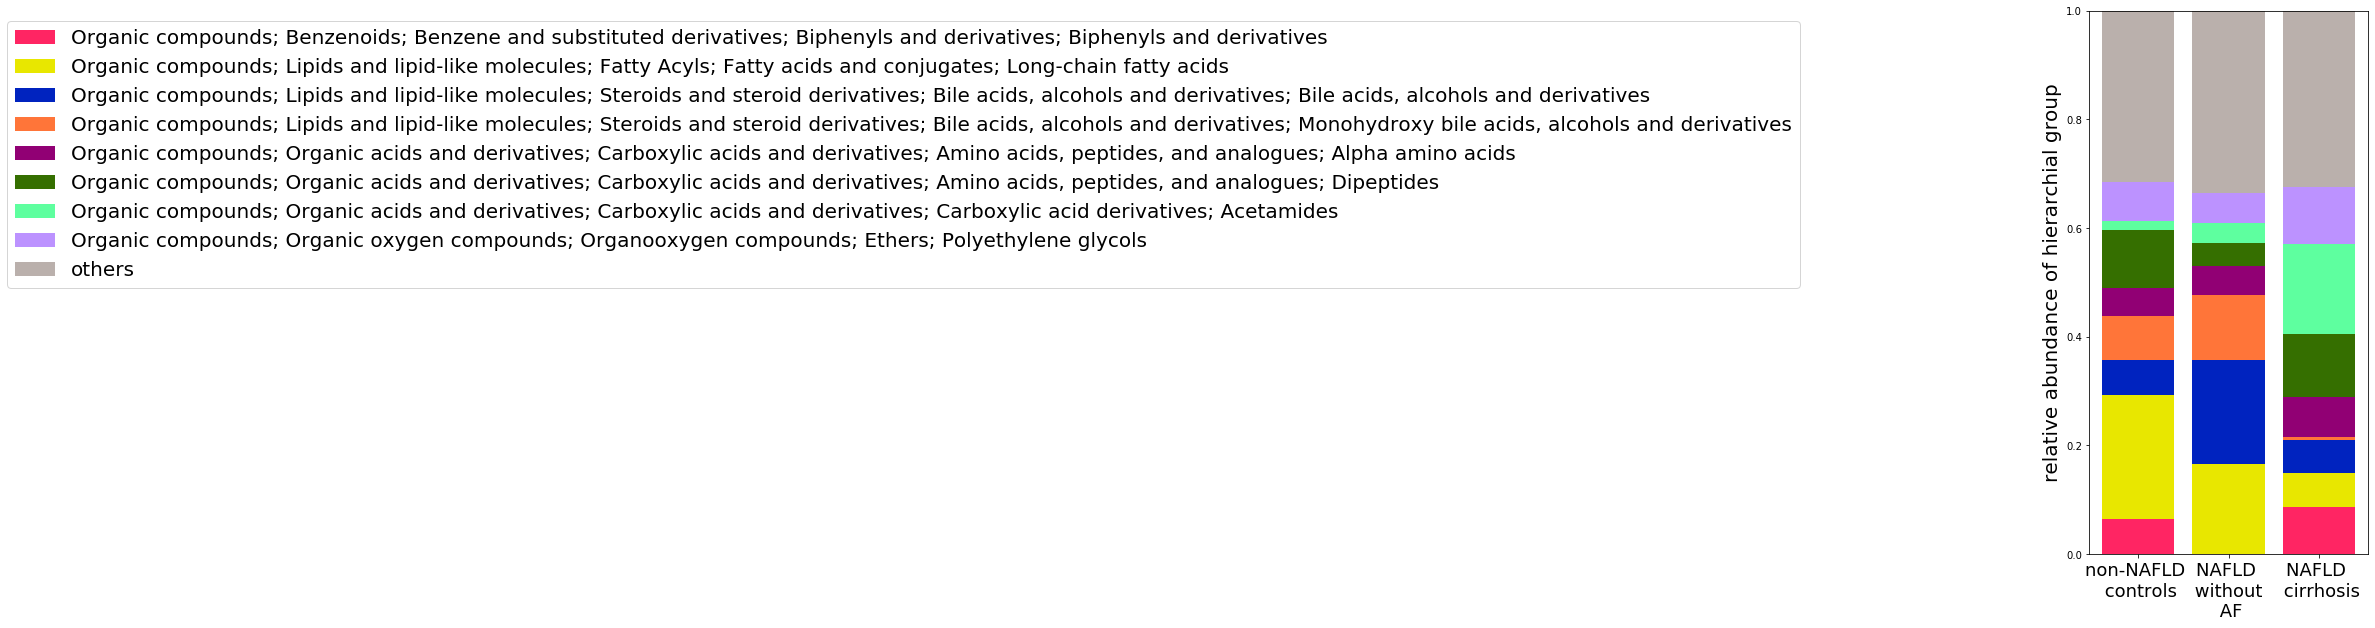

In [45]:
bar = plot_gp2(gp_to_taxa, 4,cnames=seed, numbertaxa=8, gplist=['G1P', 'G2P', 'G3P'], 
              color='assigned', lablist=['non-NAFLD \n controls', 'NAFLD \n without \n AF','NAFLD \n cirrhosis'], wide = False)

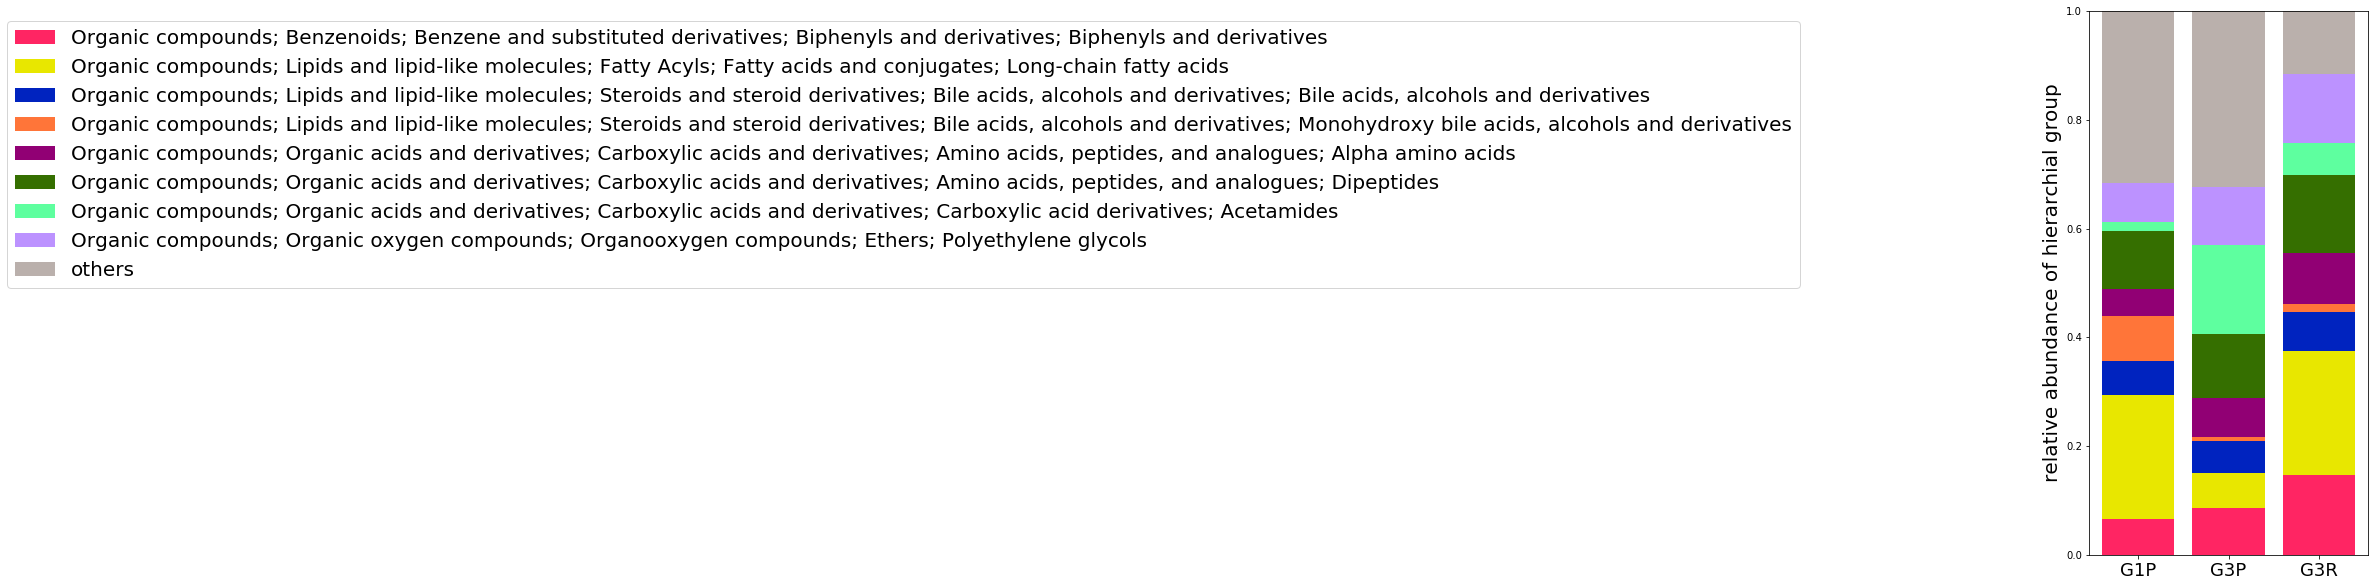

In [46]:
bar = plot_gp2(gp_to_taxa, 4,cnames=seed, numbertaxa=8, gplist=['G1P', 'G3P', 'G3R'], 
              color='assigned', lablist=['G1P','G3P','G3R'], wide = False)